# OnlineStats Integration

- OnlineStats is a Julia package for running statistical algorithms both online (one observation at a time) and in parallel.
- In this notebook we will go over how to run these calculations through JuliaDB.

First we'll load OnlineStats, JuliaDB and Plots (with GR backend)

In [30]:
using OnlineStats, JuliaDB, Plots
gr()

# force tables to print
IndexedTables.set_show_compact!(false);

Now we'll see:
1. An Intro to OnlineStats
1. An Example Using OnlineStats with `partitionplot`, `reduce`, and `groupreduce`
1. Mosaic Plots
1. Linear Regression
1. Approximate Solutions to Statistical Learning Models with `StatLearn`

# Intro to OnlineStats

#### Every stat is a type

In [31]:
m, v = Mean(), Variance()

(Mean(0.0), Variance(0.0))

#### Stats are collected in a `Series`

In [32]:
s = Series(m, v)

▦ Series{0}
│ EqualWeight | nobs=0
├── Mean(0.0)
└── Variance(0.0)

#### A `Series` can be `fit!`-ted with more data

In [33]:
fit!(s, randn(100))

▦ Series{0}
│ EqualWeight | nobs=100
├── Mean(0.0856375)
└── Variance(0.80287)

#### `Series` can be merged together

In [34]:
s2 = Series(randn(100), Mean(), Variance())

merge!(s, s2)

▦ Series{0}
│ EqualWeight | nobs=200
├── Mean(0.0493698)
└── Variance(0.856922)

### `fit!`-ting and `merge!`-ing works quite well with JuliaDB

- JuliaDB can send stats to the worker processes and then merge them at the end.

<img src="https://user-images.githubusercontent.com/8075494/32748459-519986e8-c88a-11e7-89b3-80dedf7f261b.png" width=400>

# Example: Diamonds Dataset

- OnlineStats operations are available through `partitionplot`, `reduce` and `groupreduce`.
- Here we will take a look at a dataset about diamond quality.


- First let's examine the first few rows of the data:

In [35]:
;head diamonds.csv

"","carat","cut","color","clarity","depth","table","price","x","y","z"
"1",0.23,"Ideal","E","SI2",61.5,55,326,3.95,3.98,2.43
"2",0.21,"Premium","E","SI1",59.8,61,326,3.89,3.84,2.31
"3",0.23,"Good","E","VS1",56.9,65,327,4.05,4.07,2.31
"4",0.29,"Premium","I","VS2",62.4,58,334,4.2,4.23,2.63
"5",0.31,"Good","J","SI2",63.3,58,335,4.34,4.35,2.75
"6",0.24,"Very Good","J","VVS2",62.8,57,336,3.94,3.96,2.48
"7",0.24,"Very Good","I","VVS1",62.3,57,336,3.95,3.98,2.47
"8",0.26,"Very Good","H","SI1",61.9,55,337,4.07,4.11,2.53
"9",0.22,"Fair","E","VS2",65.1,61,337,3.87,3.78,2.49


- The first column is the row number, so we'll only load the other columns.  Here we sort the data by column 2, `:carat`.

In [36]:
using JuliaDB
t = loadtable("diamonds.csv", indexcols = [2], datacols = 3:11)

Table with 53940 rows, 10 columns:
carat  cut          color  clarity  depth  table  price  x      y      z
───────────────────────────────────────────────────────────────────────────
0.2    "Premium"    "E"    "SI2"    60.2   62.0   345    3.79   3.75   2.27
0.2    "Premium"    "E"    "VS2"    59.8   62.0   367    3.79   3.77   2.26
0.2    "Premium"    "E"    "VS2"    59.0   60.0   367    3.81   3.78   2.24
0.2    "Premium"    "E"    "VS2"    61.1   59.0   367    3.81   3.78   2.32
0.2    "Premium"    "E"    "VS2"    59.7   62.0   367    3.84   3.8    2.28
0.2    "Ideal"      "E"    "VS2"    59.7   55.0   367    3.86   3.84   2.3
0.2    "Premium"    "F"    "VS2"    62.6   59.0   367    3.73   3.71   2.33
0.2    "Ideal"      "D"    "VS2"    61.5   57.0   367    3.81   3.77   2.33
0.2    "Very Good"  "E"    "VS2"    63.4   59.0   367    3.74   3.71   2.36
0.2    "Ideal"      "E"    "VS2"    62.2   57.0   367    3.76   3.73   2.33
0.2    "Premium"    "D"    "VS2"    62.3   60.0   367    

# `partitionplot`

`partitionplot(table[, x], y; by, stat, nparts, dropmissing)`

- We introduced `partitionplot` in the previous notebook.  
- Here we'll go through some more advanced examples.
- If only one variable is provided, the x-axis will be the number of observations.  
- Note that `:carat` is our index variable and thus it is sorted:

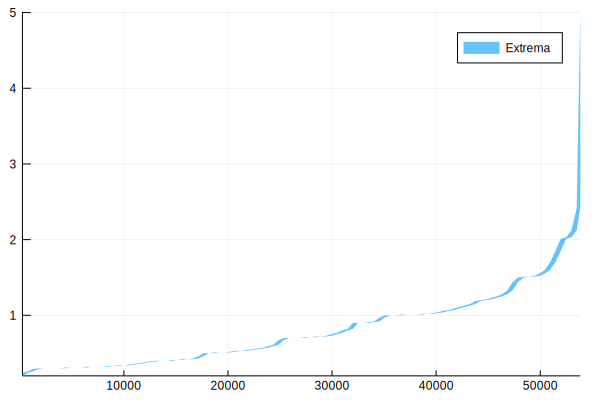

In [37]:
partitionplot(t, :carat)

- When we provide two variables, the summary of the `y` variable is plotted in each "section" of the `x` variable.  

- In this example, we'll use the Interact package to choose which statistic to summarize `y` with in the of plot `y = :price` vs. `x = :carat`:

Interact.Options{:ToggleButtons,Any}(9: "input-3" = Mean(0.0) Any , "summarizer", Mean(0.0), "Mean(0.0)", 0, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("Mean(0.0)"=>Mean(0.0),"Extrema{Float64}((Inf, -Inf))"=>Extrema{Float64}((Inf, -Inf)),"Hist: AdaptiveBins"=>Hist: AdaptiveBins), Dict{Any,Any}(Pair{Any,Any}(Mean(0.0), "Mean(0.0)"),Pair{Any,Any}(Extrema{Float64}((Inf, -Inf)), "Extrema{Float64}((Inf, -Inf))"),Pair{Any,Any}(Hist: AdaptiveBins, "Hist: AdaptiveBins"))), Any[], Any[], true, "horizontal")

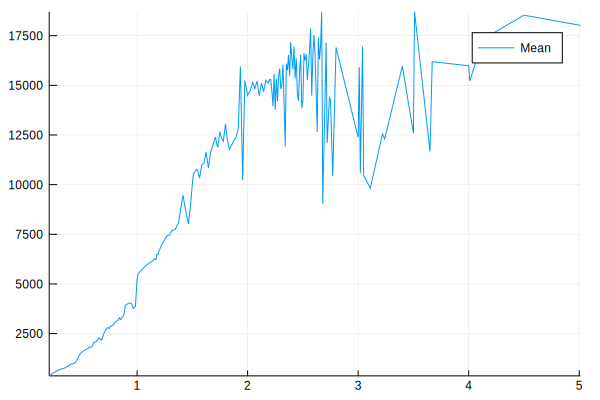

In [38]:
using Interact

@manipulate for summarizer in [Mean(), Extrema(), Hist(10)]
    partitionplot(t, :carat, :price, stat = summarizer)
end

- Any selector is a valid input to the `x` and `y` arguments of `partitionplot`:

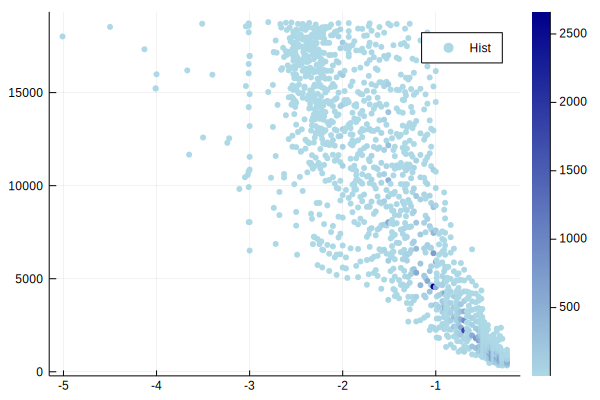

In [39]:
partitionplot(t, :carat => x -> -x, :price, stat = Hist(10))

- Any valid Plots keyword argument can also be included, such as changing the type of plot series to a barplot.

- Here we are essentially plotting `groupby(mean, t, :cut, select = :carat)`:

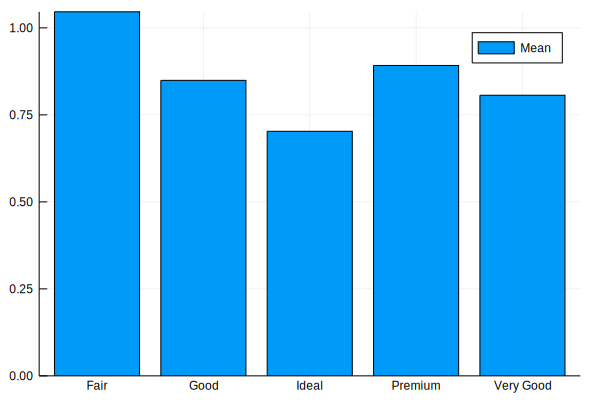

In [40]:
partitionplot(t, :cut, :carat; stat = Mean(), seriestype = :bar)

# `reduce` and `groupreduce`

- In the following examples, we'll see that the reducer for `reduce` and `groupreduce` can come from OnlineStats.  The OnlineStats reducers can be:
  1. A `Series`
  1. An `OnlineStat`
  1. A tuple of `OnlineStat`s


- Here we get the mean of `:carat` for each level of `:cut`:

In [41]:
groupreduce(Mean(), t, :cut; select = :carat)

Table with 5 rows, 2 columns:
cut          Mean
────────────────────────────────────────────────────────────────────────────────────
"Fair"       ▦ Series{0}
│ EqualWeight | nobs=1610
└── Mean(1.04614)
"Good"       ▦ Series{0}
│ EqualWeight | nobs=4906
└── Mean(0.849185)
"Ideal"      ▦ Series{0}
│ EqualWeight | nobs=21551
└── Mean(0.702837)
"Premium"    ▦ Series{0}
│ EqualWeight | nobs=13791
└── Mean(0.891955)
"Very Good"  ▦ Series{0}
│ EqualWeight | nobs=12082
└── Mean(0.806381)

- We could also calculate the same information with `groupby`
- However `[group]reduce` with an OnlineStat is often more efficient.

In [42]:
@time groupreduce(Mean(), t, :cut; select = :carat)
@time groupby(mean, t, :cut; select = :carat)

  0.002169 seconds (54.25 k allocations: 1.250 MiB)
  0.017602 seconds (161.19 k allocations: 3.293 MiB, 56.26% gc time)


Table with 5 rows, 2 columns:
cut          mean
─────────────────────
"Fair"       1.04614
"Good"       0.849185
"Ideal"      0.702837
"Premium"    0.891955
"Very Good"  0.806381

## Size of Selections

- One thing to note is that the selection in `reduce`/`groupreduce` must match the "input size" of the `OnlineStat` object passed as an argument.

- Multiple stats of the same type can be created (as type `MV`) through integer multiplication.  
- For example, if you want to calculate the means for 5 different columns, you would use as reducer:

In [43]:
5Mean()

MV{Mean}(0.0, 0.0, 0.0, 0.0, 0.0)

- In this example we create 3 histograms of 50 bins each to use the columns `:x`, `:y`, and `:z` as input:

In [44]:
hists = reduce(3Hist(50), t; select = (:x, :y, :z))

▦ Series{1}
│ EqualWeight | nobs=53940
└── MV{Hist{0,AdaptiveBins{Float64}}}(([0.0, 3.746, 3.87149, 3.96747, 4.09615, 4.29676, 4.42266, 4.57274, 4.7014, 4.81671, 4.9846, 5.14255, 5.30589, 5.4391, 5.54305, 5.70811, 5.86805, 5.99475, 6.10095, 6.20327, 6.36626, 6.50842, 6.63472, 6.76538, 6.8965, 7.01406, 7.1608, 7.32188, 7.46917, 7.6266, 7.7586, 7.86366, 7.96845, 8.113, 8.25896, 8.35794, 8.47608, 8.61803, 8.72702, 8.84526, 8.98, 9.10333, 9.256, 9.398, 9.5175, 9.655, 9.86, 10.01, 10.185, 10.74], [8, 5, 74, 487, 618, 4196, 4903, 1771, 2465, 2708, 587, 3841, 2370, 701, 462, 4320, 1668, 817, 1157, 1453, 3668, 2920, 1893, 1847, 1467, 729, 836, 1545, 1230, 667, 235, 205, 251, 872, 336, 194, 222, 66, 57, 38, 11, 12, 5, 10, 4, 2, 1, 3, 2, 1]), ([0.0, 3.76063, 3.87658, 3.98933, 4.12509, 4.3033, 4.42398, 4.58642, 4.76811, 4.91616, 5.02752, 5.1662, 5.32139, 5.4439, 5.54689, 5.72006, 5.85079, 5.95991, 6.1209, 6.26559, 6.38297, 6.48896, 6.63131, 6.7864, 6.90086, 7.02493, 7.15038, 7.28587, 7.43446, 7.5

- The printed histograms above are hard to make sense of.  
- Fortunately, OnlineStats implements many Plots recipes.  
- Plotting a `Series` object will then plot the stats it contains:

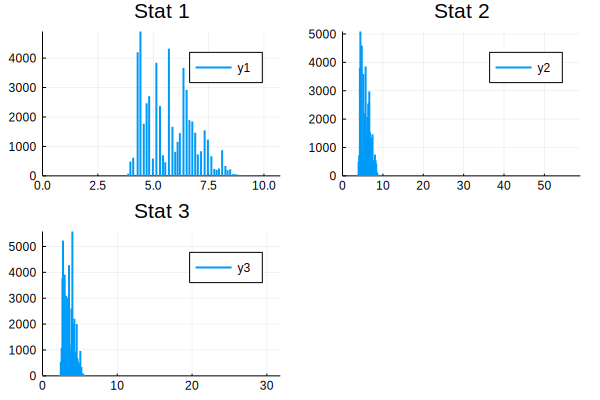

In [45]:
plot(hists, layout = 3)

- You may also want to calculate different statistics for different columns.  You can create a `Group` object with `hcat`:

In [46]:
reducer = [Mean() CountMap(String)]

Group : ("Mean", "CountMap")

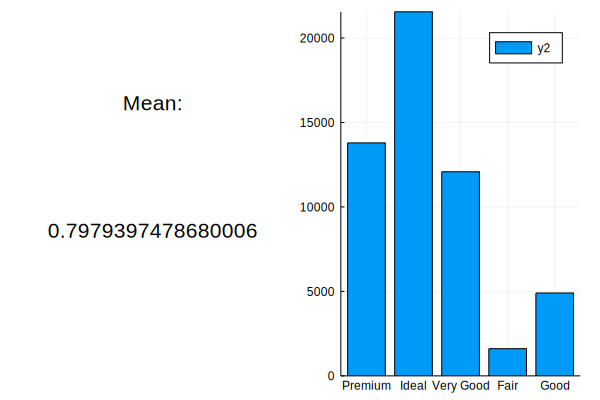

In [47]:
plot(reduce(reducer, t; select = (:carat, :cut)), layout = 2)

## Visualizing Continuous Distributions

- The `Hist` type is particularly useful for visualizing continuous distributions, as it adaptively finds the "best" bin locations.

- In the following cell, try increasing the number of bins and see how the histogram changes:

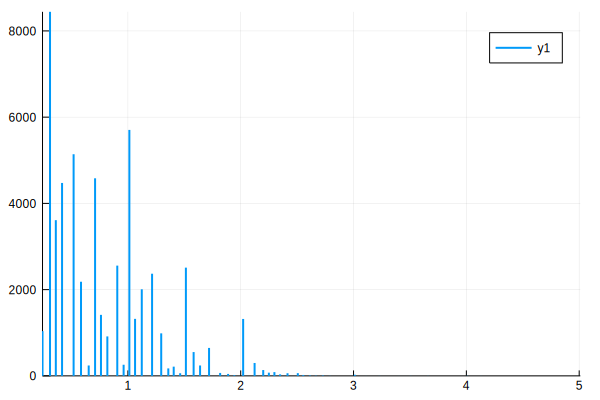

In [48]:
# try increasing the number of bins
plot(reduce(Hist(50), t; select = :carat))

## Visualizing Categorical Distributions

- The `CountMap` type tracks the number of occurrences for each unique value in a column. 
- `CountMap` accepts the column type as its argument.
- The `:cut` column is of type `String`, so here we use `CountMap(String)`:

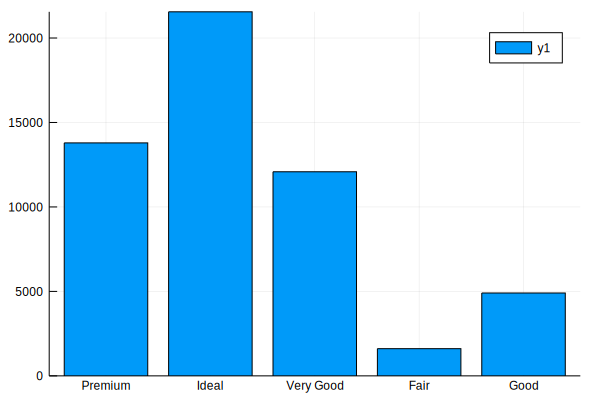

In [49]:
plot(reduce(CountMap(String), t; select = :cut))

## Mosaic Plot

- Mosaic plots are extremely useful in visualizing the association between two categorical variables, as it shows class probabilities of the `x` variables and conditional class probabilities of the `y` variable.  
- `Mosaic` accepts the two column types as its input.


- The `:cut` and `:color` variables are both of type `String`, so here we use `Mosiac(String, String)`.  
- We can see most common `:cut` is `"Ideal"` and the least common is `"Fair"` (which we already know from above).

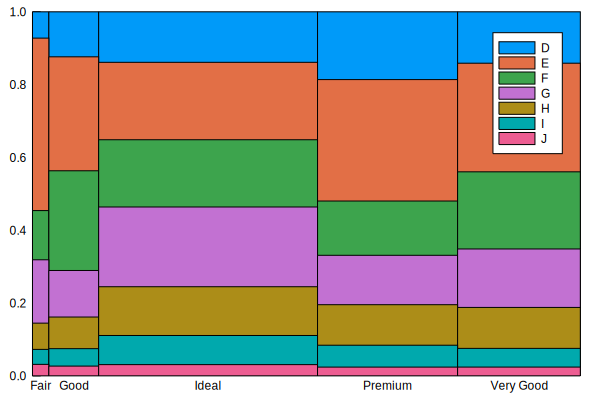

In [50]:
plot(reduce(Mosaic(String, String), t; select = (:cut, :color)))

# Statistical Models

- We can build linear (and ridge) regression models using the `LinRegBuilder` and `LinReg` types.

## `LinRegBuilder(p)`

- `LinRegBuilder` builds a data structure that allows you to regress any of the observed columns on any subset of other columns.

In [51]:
x = (:carat,:depth,:table,:price,:x,:y,:z)

s = reduce(LinRegBuilder(7), t; select = x)

▦ Series{1}
│ EqualWeight | nobs=53940
└── LinRegBuilder of 7 variables

- A `Series` holds a tuple of `OnlineStat`s in its `stats` field, so we can grab the first (in this case only) stat by indexing:

In [52]:
o = s.stats[1]

LinRegBuilder of 7 variables

- If we wish to fit a model with formula:
```
price ~ carat + depth + table + x + y + z + 1
```
  We can specify the `y` variable to be the 4-th column, which was `:price`.  By default, an intercept (bias) term is included as the last coefficient.

In [53]:
coef(o; y=4, verbose=true)

INFO: Regress 4 on [1, 2, 3, 5, 6, 7] with bias


7-element Array{Float64,1}:
 10686.3   
  -203.154 
  -102.446 
 -1315.67  
    66.3216
    41.6277
 20849.3   

- We can then create a different regression (without revisiting data) based on the formula

  ```
  carat ~ x + y + z
  ```

  by specifying the `y` and `x` variables and removing the `bias`:

In [54]:
coef(o; y=1, x = 5:7, bias = false)

3-element Array{Float64,1}:
  0.1764    
 -0.0311904 
  0.00663214

## `LinReg(p, λ)`

- The `LinReg` type allows you to fit linear regression with an optional L2 (ridge) penalty.
- `LinReg` takes the number of predictor variables as its first argument.
- One thing to note is that besides `LinRegBuilder`, models in OnlineStats expect data as a tuple: `(x, y)`.
  - This requires selections to take the form: `((xvars...), yvar)`.
  

- In this example, we'll create the model:
```
carat ~ x + y + z
```
- Note that we found the same result as we did with `LinRegBuilder` above.

In [55]:
s = reduce(LinReg(3), t; select = ((:x, :y, :z), :carat))

▦ Series{(1, 0)}
│ EqualWeight | nobs=53940
└── LinReg: β(0.0) = [0.1764 -0.0311904 0.00663214]

# Approximate Solutions to Statistical Learning

The `StatLearn` type offers many stochastic approximation algorithms for fitting regularized statistical learning models that are linear in the parameters, including:

- `L2DistLoss()` (Linear Regression)
- `LogitMarginLoss()` (Logistic Regression)
- `PoissonLoss()` (Poisson Regression)
- `QuantileLoss(q)` (Quantile Regression)
- `HuberLoss(a)` (Huber-Loss Regression)
- `L1DistLoss()` (L1-Loss Regression)
- `L1HingeLoss()` (Linear SVMs)
- `DWDLoss(q)` (Generalized Distance Weighted Discrimination)

The models can be regularized to prevent overfitting with penalties such as

- `NoPenalty`
- `L2Penalty` (Ridge)
- `L1Penalty` (LASSO)
- `ElasticNetPenalty` (Weighted Average of Ridge and LASSO)

---

- The concepts in stochastic approximation are beyond the scope of this tutorial.
- A starting point for interested readers:

In [56]:
?StatLearn

search: StatLearn



```
StatLearn(p::Int, args...)
```

Fit a statistical learning model of `p` independent variables for a given `loss`, `penalty`, and `λ`.  Additional arguments can be given in any order (and is still type stable):

  * `loss = .5 * L2DistLoss()`: any Loss from LossFunctions.jl
  * `penalty = L2Penalty()`: any Penalty (which has a `prox` method) from PenaltyFunctions.jl.
  * `λ = fill(.1, p)`: a Vector of element-wise regularization parameters
  * `updater = SGD()`: [`SGD`](@ref), [`ADAGRAD`](@ref), [`ADAM`](@ref), [`ADAMAX`](@ref), [`MSPI`](@ref)

# Details

The (offline) objective function that StatLearn approximately minimizes is

$\frac{1}{n}\sum_{i=1}^n f_i(\beta) + \sum_{j=1}^p \lambda_j g(\beta_j),$

where the $f_i$'s are loss functions evaluated on a single observation, $g$ is a penalty function, and the $\lambda_j$s are nonnegative regularization parameters.

# Example

```
using LossFunctions, PenaltyFunctions
x = randn(100_000, 10)
y = x * linspace(-1, 1, 10) + randn(100_000)
o = StatLearn(10, .5 * L2DistLoss(), L1Penalty(), fill(.1, 10), SGD())
s = Series(o)
fit!(s, x, y)
coef(o)
predict(o, x)
```
